# Accelerated Multiscale Pyramid Generation

This example demonstrates accelerated multiscale image pyramid generation for registration in ITK with VkFFT.

Pairwise image registration concerns iterative alignment of two N-dimensional images. When aligning large, detailed images it is often useful to initialize global alignment by blurring and registering images before refining local alignment on more detailed images. An image scale space can be constructed by iteratively applying Gaussian blurring of different strengths, ranging from very blurred (0th image) to very detailed (nth image).

ITK defines `itk.MultiScalePyramidImageFilter` which makes use of Gaussian blurring and subsequent resampling methods to construct and output an image scale space. Blurring is accomplished via convolution of an image with a Gaussian kernel. Spatial convolution with `itk.DiscreteGaussianImageFilter` runs quickly with very small kernels, but can be very slow for convolution of large images with large kernels. `itk.FFTDiscreteGaussianImageFilter`, by comparison, runs convolution in the frequency domain with a performance that is much less sensitive to kernel size, but is typically slower than spatial convolution for small kernels.

`itk.VkMultiScalePyramidImageFilter` balances these smoothing options by polling the kernel size for each level and selecting the appropriate smoothing filter. In this example we demonstrate multiscale pyramid generation and compare performance between the default ITK pyramid image filter and the accelerated ITK VkFFT pyramid image filter.

In [1]:
import sys
#!{sys.executable} -m pip install matplotlib itk itk-vkfft

In [2]:
import os
import time
import math

import itk
import numpy as np
import matplotlib.pyplot as plt

assert 'VkMultiResolutionPyramidImageFilter' in dir(itk)

### Define Input

For demonstration purposes we generate a contrived large 3D input image. The image in question contains significant speckle noise and a large, uniform box. Slices along the 0th (i) image axis are visualized throughout the example.

Image size: itkSize3 ([500, 500, 500])


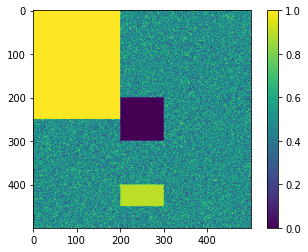

In [3]:
ImageDimension = 3
PixelType = itk.F
ImageType = itk.Image[PixelType, ImageDimension]

# Create a default 3D image with a large, continuous feature
def create_random_image(image_size:list=[500,500,500]) -> ImageType:
    arr = np.random.rand(*image_size).astype(np.float32)
    arr[0:80,0:250,0:200] = 1
    arr[0:10,200:300,200:300] = 0
    arr[0:400,400:450,200:300] = 0.9
    return itk.image_from_array(arr)

image = create_random_image()
print(f'Image size: {itk.size(image)}')
plt.imshow(image[0,:,:])
plt.colorbar()
plt.show()

### Prepare Acceleration Overrides

Factory mechanisms for VkFFT overrides are introduced ITK Python v5.3rc04. With these changes VkFFT filters are implicitly set as the default backend for ITK FFT if `itk-vkfft` is built or installed, no user steps are required.

The user may elect to manually set the default for VkFFT filters to use. This is mostly relevant on systems where more than one device is compatible with the accelerated backend, such as a laptop with OpenCL drivers for both CPU and notebook GPU. The user is responsible for selecting the correct device for their system. A tool such as `clinfo` may be used to query this information.

In [4]:
# Verify whether VkFFT is default backend
def is_acceleration_available():
    ComplexImageType = itk.Image[itk.complex[PixelType],ImageDimension]
    basefft_type = itk.ForwardFFTImageFilter[ImageType,ComplexImageType]

    # Check whether VkFFT is default FFT implementation (expected)
    fft_filter = basefft_type.New()
    if fft_filter.GetNameOfClass() != 'VkForwardFFTImageFilter':
        print(f'VkFFT was not found as the default FFT backend. Please verify itk>=5.3rc04 and itk-vkfft>=0.1.4.')
        return False
    
    return True

assert is_acceleration_available()

In [5]:
itk.VkGlobalConfiguration.SetDeviceID(1)  # Select the appropriate OpenCL device

Note: VkFFT-accelerated performance can be leveraged in any ITK filter 
that makes use of the default `itk.MultiResolutionPyramidImageFilter` via
object factory overrides. Uncomment the code below and re-run the notebook to see accelerated performance introduced on top of the underlying class with minimal user intervention.

In [6]:
# itk.VkMultiResolutionPyramidImageFilterFactory.RegisterOneFactory()

## Pyramid Generation Comparison

A six-level scale space is generated for the input image according to a default schedule. We first run fully CPU-based multiresolution pyramid generation and visualize results, then compare with performance and output from the partially accelerated `itk.VkMultiResolutionPyramidImageFilter`.

In [7]:
n_levels = 6
base_filter_type = itk.MultiResolutionPyramidImageFilter[ImageType,ImageType]
vk_filter_type = itk.VkMultiResolutionPyramidImageFilter[ImageType,ImageType]

### Baseline Pyramid Generation

In [8]:
def initialize_pyramid_filter(pyramid_filter_type, n_levels:int=4):
    pyramid_filter = pyramid_filter_type.New()
    pyramid_filter.SetInput(image)
    pyramid_filter.SetNumberOfLevels(n_levels)    
    return pyramid_filter

default_pyramid_filter = initialize_pyramid_filter(base_filter_type, n_levels)

In [9]:
def print_schedule(pyramid_filter:base_filter_type):
    schedule = pyramid_filter.GetSchedule()
    print(f'Schedule size: {schedule.rows()} levels x {schedule.cols()} dimensions\n')

    print(f'\t\ti\tj\tk')
    for i in range(schedule.rows()):
        print(f'Level {str(i)}:\t' + '\t'.join([str(schedule.GetElement(i,j)) for j in range(schedule.cols())]))
        
print_schedule(default_pyramid_filter)

Schedule size: 6 levels x 3 dimensions

		i	j	k
Level 0:	32	32	32
Level 1:	16	16	16
Level 2:	8	8	8
Level 3:	4	4	4
Level 4:	2	2	2
Level 5:	1	1	1


In [10]:
# Profile pyramid generation
def generate_pyramid(pyramid_filter) -> float:
    starttime = time.time()
    print(f'Updating {pyramid_filter.GetNameOfClass()}')
    pyramid_filter.Update()
    endtime = time.time()
    
    elapsed_time = endtime - starttime
    print(f'Generated pyramid in {elapsed_time:0.4f} s')
    return elapsed_time
    
baseline_elapsed_time = generate_pyramid(default_pyramid_filter)

Updating MultiResolutionPyramidImageFilter
Generated pyramid in 51.8270 s


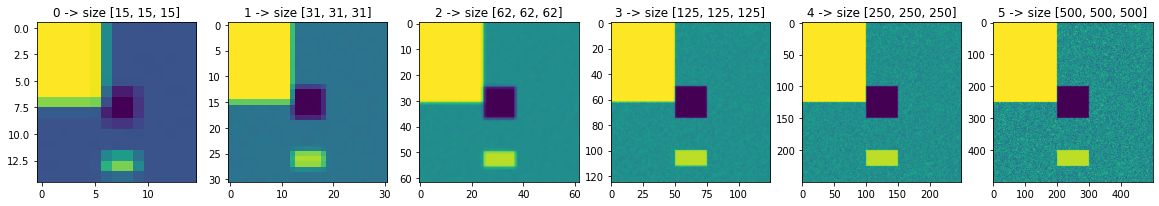

In [11]:
# Plot image output levels from least to most detailed.
def plot_output(pyramid_filter:base_filter_type):
    n_levels = pyramid_filter.GetNumberOfLevels()
    fig, axs = plt.subplots(nrows=1, ncols=n_levels, figsize=(20,20))
    axs = np.expand_dims(axs,0)

    for row in range(1):
        for col in range(n_levels):
            output_image = pyramid_filter.GetOutput(row * n_levels + col)
            if(math.isnan(np.max(output_image))):
                print(f'Got nan at level {col}')
                
            axs[row,col].imshow(output_image[0,:,:])
            axs[row,col].set_title(f'{row * n_levels + col} -> size {list(itk.size(output_image))}')

    plt.show()
    
plot_output(default_pyramid_filter)

### GPU Accelerated Pyramid Generation

FFT convolution is enabled as the default blurring mechanism, subsequently leveraging VkFFT GPU acceleration. The same multiscale pyramid as above is generated from scratch.

Threshold parameters controlling the conditions under which CPU spatial convolution or GPU FFT convolution are run are derived from benchmark results in the [GaussianBlurBenchmark](GaussianBlurBenchmark.ipynb) notebook.

In [12]:
accelerated_pyramid_filter = initialize_pyramid_filter(vk_filter_type,n_levels)

# Use spatial convolution for small-kernel blurring, and switch to 
# FFT convolution when the kernel radius exceeds 10 voxels in any 1 direction
accelerated_pyramid_filter.SetKernelRadiusThreshold(10)
accelerated_pyramid_filter.SetKernelThresholdDimension(1)

print_schedule(accelerated_pyramid_filter)

for level in range(n_levels):
    radius = accelerated_pyramid_filter.GetKernelRadius(level)
    useFFT = accelerated_pyramid_filter.GetUseFFT(radius)
    print(f'Level {level} -> kernel radius {list(radius)}, use FFT: {useFFT}')

Schedule size: 6 levels x 3 dimensions

		i	j	k
Level 0:	32	32	32
Level 1:	16	16	16
Level 2:	8	8	8
Level 3:	4	4	4
Level 4:	2	2	2
Level 5:	1	1	1
Level 0 -> kernel radius [27, 27, 27], use FFT: True
Level 1 -> kernel radius [13, 13, 13], use FFT: True
Level 2 -> kernel radius [7, 7, 7], use FFT: False
Level 3 -> kernel radius [3, 3, 3], use FFT: False
Level 4 -> kernel radius [2, 2, 2], use FFT: False
Level 5 -> kernel radius [1, 1, 1], use FFT: False


In [13]:
accelerated_elapsed_time = generate_pyramid(accelerated_pyramid_filter)

Updating VkMultiResolutionPyramidImageFilter
Generated pyramid in 22.6324 s


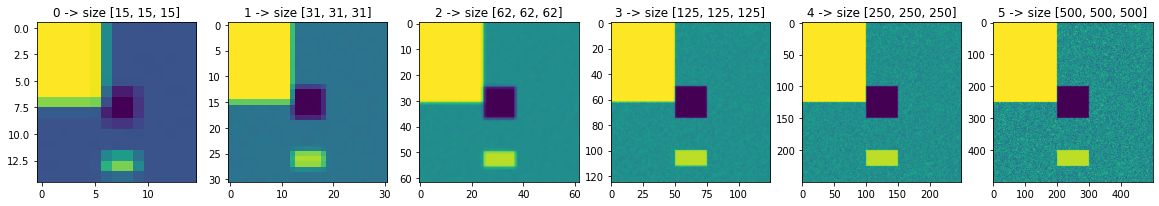

In [14]:
plot_output(accelerated_pyramid_filter)

### Compare Performance

In [18]:
relative_speed = baseline_elapsed_time / accelerated_elapsed_time
diff = baseline_elapsed_time - accelerated_elapsed_time
speedup = 1 - (accelerated_elapsed_time / baseline_elapsed_time)
print(f'Relative speed of VkFFT-accelerated pyramid generation was {relative_speed:0.1%} ({diff:0.2f} s)')

Relative speed of VkFFT-accelerated pyramid generation was 229.0% (29.19 s)
